Table of Content

1. Intro & Business Understanding

2. Exploratory Data Analysis

3. Feature Engineering

4. Clustering Models & User Segment Insights

5. Conclusion and Business Applications

## Section 1: Intro & Business Understanding

Duolingo aims to use the user survey to develop user segments (or personas) for future marketing effort and product improvement. Besides survey data, usage data from the users in the survey are also provided. This usage data helps enrich the insights of users.

For this task, you have three objectives:

There are 3 key objectives of this data analysis project:
1) Explore the data
For this part, I’m curious about:
- Exploratory data analysis: 
    - Data quality: missing values, duplicated data
    - Key questions I want to discover: 
        - Overall information about Duolingo users
        - Who are the most engaging users? And why?
        - Who are the subscribers? What made them subscriber?
        - The reliability of survey
- Feature engineering: 
    - What are the variables that are useful for the model?
    - What are necessary transformation on variables?

2) Use quantitative methods to identify a set of user segments/personas
- I will use 2 most common clustering models to classify user segments/personas: K-means clustering and Hierarchical Clustering
- After that, visualizing segments to figure out the insights of each segment/persona.

3) Identify any actionable product or marketing insights
- Provide key insights and recommendation for product imrovement and marketing initiatives.
- Go above and beyond by asking relevant questions to further have a deep-dive analysis.


## Section 2: Exploratory Data Analysis <a id="2"></a>

In [99]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

### Survey Data <a id="data-overview"></a>

In [100]:
# Read survey_data file
survey_data = pd.read_csv('survey_data.csv')
survey_data.shape

(6187, 19)

There are 6187 surveys with 19 columns.

In [101]:
# A preview of survey data
survey_data.head()

,user_id,age,annual_income,country,duolingo_platform,duolingo_subscriber,duolingo_usage,employment_status,future_contact,gender,other_resources,primary_language_commitment,primary_language_review,primary_language_motivation,primary_language_motivation_followup,primary_language_proficiency,student,survey_complete,time_spent_seconds
0,35c9fc6e72c911e99681dca9049399ef,18-34,"$26,000 - $75,000",JP,Android phone or tablet,"No, I have never paid for Duolingo Plus",Daily,Employed full-time,Yes,Male,"Stories/novels/children's books,Movies/TV Shows",I'm very committed to learning this language.,I am using Duolingo to review a language I've ...,I like to learn new languages,"I want to learn as many languages as I can,Oth...",Advanced,Not currently a student,1,193
1,35c9fdde72c911e98630dca9049399ef,18-34,"$26,000 - $75,000",JP,iPhone or iPad,"No, I have never paid for Duolingo Plus",Weekly,Employed full-time,Yes,Male,NaN,I'm slightly committed to learning this language.,I am using Duolingo to review a language I've ...,I need to be able to speak the local language ...,"I am an immigrant,I am a refugee",Intermediate,Not currently a student,1,139
2,35c9feb072c911e9ab4cdca9049399ef,18-34,"$76,000 - $150,000",JP,iPhone or iPad,"Yes, I currently pay for Duolingo Plus",Daily,Employed full-time,Yes,Male,NaN,I'm moderately committed to learning this lang...,I am using Duolingo to review a language I've ...,I want to connect with my heritage or identity,NaN,Beginner,Not currently a student,1,119
3,35c9ff7072c911e9900ddca9049399ef,18-34,"$76,000 - $150,000",JP,iPhone or iPad,"No, but I have previously paid for Duolingo Plus",Daily,Employed full-time,Yes,Female,Other apps,I'm very committed to learning this language.,I am using Duolingo to learn this language for...,I am preparing for a trip,I want to learn some basics in the local langu...,Intermediate,Not currently a student,1,229
4,35ca002672c911e99effdca9049399ef,35 - 54,"$76,000 - $150,000",JP,Android phone or tablet,"Yes, I currently pay for Duolingo Plus",Daily,Employed full-time,Yes,Male,NaN,I'm very committed to learning this language.,I am using Duolingo to learn this language for...,I want to connect with my heritage or identity,NaN,Intermediate,Not currently a student,1,157


In [102]:
# Check basic information of survey data
survey_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6187 entries, 0 to 6186
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   user_id                               6187 non-null   object
 1   age                                   5838 non-null   object
 2   annual_income                         5182 non-null   object
 3   country                               6187 non-null   object
 4   duolingo_platform                     5911 non-null   object
 5   duolingo_subscriber                   5901 non-null   object
 6   duolingo_usage                        5911 non-null   object
 7   employment_status                     5730 non-null   object
 8   future_contact                        5446 non-null   object
 9   gender                                5838 non-null   object
 10  other_resources                       4474 non-null   object
 11  primary_language_commitment   

Hmm there are missing values at many columns.

In [103]:
# Bu first, let's check duplicated user_id
duplicated_user_ids = survey_data[survey_data.duplicated(subset='user_id', keep=False)]
duplicated_user_ids['user_id'].nunique()

37

Oh there are 37 duplicated unique user_ids. After checking, I figured out that most of duplicated user_id has records in 2 different countries. I decided to remove those user_id! Will make a note for the data team for further exploration on this issue!

In [104]:
# Let's remove rows with duplicated user_id
survey_data = survey_data.drop_duplicates(subset='user_id').reset_index()
survey_data.shape

(6150, 20)

In [105]:
# Now, let's take a closer look at missing values: percentage of missing values
round(survey_data.isnull().sum()/len(survey_data) * 100,2).sort_values(ascending=False)

primary_language_motivation_followup    39.95
other_resources                         27.74
annual_income                           16.29
future_contact                          11.98
student                                 10.75
employment_status                        7.41
gender                                   5.66
age                                      5.66
duolingo_subscriber                      4.63
duolingo_platform                        4.47
duolingo_usage                           4.47
primary_language_motivation              3.87
primary_language_review                  2.80
primary_language_commitment              2.67
primary_language_proficiency             2.59
survey_complete                          0.00
index                                    0.00
user_id                                  0.00
country                                  0.00
time_spent_seconds                       0.00
dtype: float64

Many columns have missing values, ranging from 2 to 40%. I think one of the reason is that there are some incomplete surveys. Let's check!

In [106]:
# Check how much percentage there is for incomplete surveys
round(len(survey_data[survey_data['survey_complete'] == 0]) / len(survey_data) * 100, 2)

7.43

There are 7.4% uncompleted data. Let see if we remove those incomplete survey, how many missing values are left?

In [107]:
# Check how much percentage there is for incomplete surveys - after removing incomplete survey
round(survey_data[survey_data['survey_complete'] == 1].isnull().sum()/len(survey_data[survey_data['survey_complete'] == 1]) * 100,2).sort_values(ascending=False)

primary_language_motivation_followup    37.84
other_resources                         24.66
annual_income                           11.12
student                                  5.39
future_contact                           4.92
employment_status                        1.93
duolingo_subscriber                      0.35
primary_language_motivation              0.26
primary_language_review                  0.23
duolingo_usage                           0.21
duolingo_platform                        0.19
gender                                   0.18
age                                      0.16
primary_language_commitment              0.11
primary_language_proficiency             0.07
survey_complete                          0.00
index                                    0.00
user_id                                  0.00
country                                  0.00
time_spent_seconds                       0.00
dtype: float64

My assumption seems correct! For some columns such as annual income and student, we can base on the age to fill in missing values.

In [108]:
# Get the most common annual income by age, then I will use this value to replace null missing value
## Count number of annual income range by age
income_by_age = survey_data.groupby(['age', 'annual_income']).size().reset_index(name='count')

## Find the index of the maximum count for each age group
max_indices = income_by_age.groupby('age')['count'].idxmax()

## Get the most common annual income and its count for each age group
most_common_income_by_age = income_by_age.loc[max_indices]

most_common_income_by_age


,age,annual_income,count
0,18-34,"$0 - $10,000",801
8,35 - 54,"$26,000 - $75,000",599
13,55 - 74,"$26,000 - $75,000",377
18,75 or older,"$26,000 - $75,000",41
20,Under 18,"$0 - $10,000",273


Cool! We can use those income range to replace for the null values!

In [109]:
# Create an age-income mapping based on the output above
age_income_mapping = {
    '18-34': '$0 - $10,000',
    '35 - 54': '$26,000 - $75,000',
    '55 - 74': '$26,000 - $75,000',
    '75 or older': '$26,000 - $75,000',
    'Under 18': '$0 - $10,000'
}

# Let's replace!
for i in range(len(survey_data)):
    if pd.isnull(survey_data.at[i, 'annual_income']):
        age_above = survey_data.at[i - 1, 'age']  # Get the age group above
        survey_data.at[i, 'annual_income'] = age_income_mapping.get(age_above, np.nan)

For student, it's much more intuitive!

In [110]:
# Count number of student status by age
student_by_age = survey_data.groupby(['age', 'student']).size().reset_index(name='count')
student_by_age

,age,student,count
0,18-34,Full-time student,461
1,18-34,Not currently a student,1106
2,18-34,Part-time student,195
3,35 - 54,Full-time student,13
4,35 - 54,Not currently a student,1810
5,35 - 54,Part-time student,103
6,55 - 74,Full-time student,6
7,55 - 74,Not currently a student,1319
8,55 - 74,Part-time student,33
9,75 or older,Not currently a student,113


We can easily realize that for under 18 group, they are mostly full-time students. For other groups, the majority is "Not currently a student"

In [111]:
# Create age-student mapping
age_student_mapping = {
    '18-34': 'Not currently a student',
    '35 - 54': 'Not currently a student',
    '55 - 74': 'Not currently a student',
    '75 or older': 'Not currently a student',
    'Under 18': 'Full-time student'
}


# Let's replace!
for i in range(len(survey_data)):
    if pd.isnull(survey_data.at[i, 'student']):
        age_above = survey_data.at[i - 1, 'age']  # Get the age group above
        survey_data.at[i, 'student'] = age_student_mapping.get(age_above, np.nan)

Let's check the result after our effort of handling missing values!

In [112]:
# Check how much percentage there is for incomplete surveys - after removing incomplete survey
round(survey_data[survey_data['survey_complete'] == 1].isnull().sum()/len(survey_data[survey_data['survey_complete'] == 1]) * 100,2).sort_values(ascending=False)

primary_language_motivation_followup    37.84
other_resources                         24.66
future_contact                           4.92
employment_status                        1.93
duolingo_subscriber                      0.35
annual_income                            0.30
primary_language_motivation              0.26
primary_language_review                  0.23
duolingo_usage                           0.21
duolingo_platform                        0.19
gender                                   0.18
age                                      0.16
student                                  0.12
primary_language_commitment              0.11
primary_language_proficiency             0.07
survey_complete                          0.00
index                                    0.00
user_id                                  0.00
country                                  0.00
time_spent_seconds                       0.00
dtype: float64

The percentage of missing values for age and student reduces significantly. For columns such as primary_language_motivation_followup, other_resources and future_contact, I'm thinking they are not useful for the clustering model. So just keep it there first!
Let's discover some insights from the dataset.

Let check the values for each column

In [113]:
# Count values by each categorical column
for column in survey_data[['country', 'duolingo_platform',	'duolingo_subscriber',	'duolingo_usage',	'employment_status',	'future_contact',	'gender',	'primary_language_commitment',	'primary_language_review',	'primary_language_motivation',	'primary_language_proficiency',	'student',	'survey_complete']].columns:
    print( survey_data[column].value_counts())
    print('-------------------')

country
FR    996
JP    895
MX    886
RU    682
GB    655
DE    619
US    456
BR    373
CO    313
TW    275
Name: count, dtype: int64
-------------------
duolingo_platform
Android phone or tablet    2582
iPhone or iPad             2474
Web browser                 819
Name: count, dtype: int64
-------------------
duolingo_subscriber
No, I have never paid for Duolingo Plus             3895
Yes, I currently pay for Duolingo Plus              1606
I don't know if I pay for Duolingo Plus              212
No, but I have previously paid for Duolingo Plus     152
Name: count, dtype: int64
-------------------
duolingo_usage
Daily                     4311
Weekly                    1067
Monthly                    290
Less than once a month     177
I don't use Duolingo        30
Name: count, dtype: int64
-------------------
employment_status
Employed full-time    2891
Retired               1032
Unemployed             933
Employed part-time     838
Name: count, dtype: int64
-------------------
futu

In [114]:
# Let's take a look at how much time users spent on this survey
survey_data['time_spent_seconds'].describe()

count      6150.000000
mean       3342.838211
std       26346.767242
min        -297.000000
25%         234.000000
50%         325.500000
75%         470.000000
max      584939.000000
Name: time_spent_seconds, dtype: float64

There are some people spending negative time filling this survey! Let's remove them!

In [115]:
# Take a look at the time spent distribution
np.percentile(survey_data['time_spent_seconds'], np.arange(1, 100,3))

array([-165.12,   77.96,  152.  ,  173.  ,  188.  ,  201.  ,  212.  ,
        223.  ,  234.  ,  245.  ,  256.  ,  265.  ,  276.  ,  287.  ,
        299.  ,  310.  ,  321.01,  335.  ,  347.  ,  360.  ,  375.89,
        390.  ,  409.  ,  428.  ,  453.  ,  481.  ,  510.71,  555.18,
        615.  ,  691.12,  818.59, 1107.06, 3507.95])

In [116]:
# I will filter out the survey that has time spent less than 30 seconds or more than 3500 seconds.
survey_data = survey_data[(survey_data['time_spent_seconds']>=30)]
survey_data = survey_data[(survey_data['time_spent_seconds']<3500)]

survey_data.shape

(5794, 20)

### App Usage ###

In [117]:
# Read the App Usage data
app_usage = pd.read_csv('survey_users_app_usage.csv')
app_usage.drop(columns='Unnamed: 12', inplace= True, axis=1)
app_usage.head()

,user_id,duolingo_start_date,daily_goal,highest_course_progress,took_placement_test,purchased_subscription,highest_crown_count,n_active_days,n_lessons_started,n_lessons_completed,longest_streak,n_days_on_platform
0,35cb7e8f72c911e9888edca9049399ef,1/10/22 21:14,NaN,46.0,True,False,277.0,88,741.0,668.0,135,137
1,35ca34fd72c911e99ed6dca9049399ef,2/28/21 5:01,NaN,50.0,True,False,62.0,16,57.0,57.0,6,453
2,35d1a54a72c911e98e25dca9049399ef,5/7/18 17:55,1.0,71.0,False,False,202.0,29,315.0,295.0,55,1481
3,35d4beb072c911e9aa92dca9049399ef,4/27/22 9:28,NaN,2.0,False,False,2.0,3,6.0,5.0,1,30
4,35ccf4bd72c911e9be2edca9049399ef,4/9/19 3:16,NaN,34.0,False,False,216.0,57,338.0,297.0,56,1144


This data mainly contains engagement metrics, helping provide more insights for the survey data.

In [118]:
# Let's merge survey and app usage data for further exploration.
merged_data = pd.merge(survey_data, app_usage, on='user_id', how='inner')

1. Let's check the reliability of the survey, by quickly comparing some information, such as subscription info between survey and app usage data.

In [119]:
# Percentage of actual subscribers by age (during the sample period)
merged_data[merged_data['purchased_subscription'] == 1]['age'].value_counts()/merged_data['age'].value_counts()

age
18-34          0.248662
35 - 54        0.337513
55 - 74        0.435191
75 or older    0.488000
Under 18       0.096774
Name: count, dtype: float64

In [120]:
# Percentage of subscriber status (according to the survey) by age (during the sample period plus previous time)
merged_data[(merged_data['duolingo_subscriber'] == 'Yes, I currently pay for Duolingo Plus') | (merged_data['duolingo_subscriber'] == 'No, but I have previously paid for Duolingo Plus')]['age'].value_counts()/merged_data['age'].value_counts()

age
18-34          0.214158
35 - 54        0.321317
55 - 74        0.416387
75 or older    0.480000
Under 18       0.077419
Name: count, dtype: float64

We see that the percentage in both data sources is quite consistent. Therefore, the quality of the survey is quite good!
- Note: in the survey, I also counted the option "No, but I have previously paid for Duolingo Plus", because users may just cancel their subscription in the sample period. But no worries, the option "Yes, I currently pay for Duolingo Plus" is much more significant!

2. Let's see engagement by age

In [121]:
# Get engagement metrics by age
merged_data.groupby('age')[['daily_goal', 'highest_course_progress','highest_crown_count', 'n_active_days', 'n_lessons_started', 'n_lessons_completed','longest_streak','n_days_on_platform']].median().style.background_gradient(cmap='RdYlGn')

,daily_goal,highest_course_progress,highest_crown_count,n_active_days,n_lessons_started,n_lessons_completed,longest_streak,n_days_on_platform
age,,,,,,,,
18-34,20.000000,22.000000,59.000000,27.000000,108.000000,99.000000,10.000000,433.000000
35 - 54,20.000000,29.000000,95.000000,55.000000,188.000000,174.000000,24.000000,416.000000
55 - 74,20.000000,31.000000,126.000000,73.000000,257.500000,238.000000,35.000000,475.000000
75 or older,20.000000,33.000000,122.000000,79.000000,271.000000,242.000000,33.000000,656.000000
Under 18,20.000000,10.000000,22.500000,13.000000,51.000000,41.000000,3.000000,150.500000


It's clear that the older the users are, the better their learning engagement is!

3. Let's see some insights for the subscriber group.

In [122]:
# Percentage of subscription by age
subscription_count_by_age = merged_data.groupby('age')[['purchased_subscription']].sum() /  merged_data.groupby('age')[['purchased_subscription']].count()
subscription_count_by_age.style.background_gradient(cmap='RdYlGn')

,purchased_subscription
age,
18-34,0.248662
35 - 54,0.337513
55 - 74,0.435191
75 or older,0.488000
Under 18,0.096774


Wow, it's the older users who subscribe more! For sure, the engagement of subscribers will much higher than non-subscribers!

In [123]:
# Get engagement metrics of subscribers
merged_data.groupby('purchased_subscription')[['daily_goal', 'highest_course_progress','highest_crown_count', 'n_active_days', 'n_lessons_started', 'n_lessons_completed','longest_streak','n_days_on_platform'   ]].median().style.background_gradient(cmap='RdYlGn')

,daily_goal,highest_course_progress,highest_crown_count,n_active_days,n_lessons_started,n_lessons_completed,longest_streak,n_days_on_platform
purchased_subscription,,,,,,,,
False,20.000000,21.000000,61.000000,28.000000,107.000000,98.000000,7.000000,375.000000
True,20.000000,33.000000,134.000000,82.000000,294.000000,276.000000,71.000000,496.000000


Yeah no big surprise! How about subscription by country?

In [124]:
# Percentage of subscription by country

subscription_count_by_country = merged_data.groupby('country')[['purchased_subscription']].sum() / merged_data.groupby('country')[['purchased_subscription']].count()
subscription_count_by_country.style.background_gradient(cmap='RdYlGn') 

,purchased_subscription
country,
BR,0.028571
CO,0.017544
DE,0.036458
FR,0.540827
GB,0.039474
JP,0.565269
MX,0.480334
RU,0.580997
TW,0.027237


Countries, including France, Japan, Mexico and Russia have impressive subscription rate (48-58%)

4. Let's see some commitment behind!

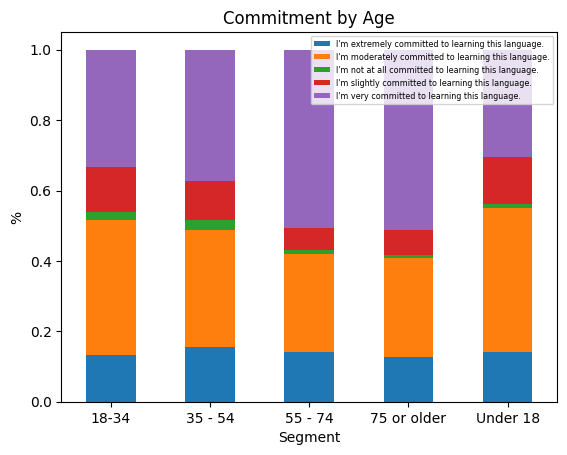

In [125]:
commitment_by_age = (merged_data.groupby('age')['primary_language_commitment']
                            .value_counts(normalize=True)
                            .unstack('primary_language_commitment')
                            .plot.bar(stacked=True))

    # Add title and labels
plt.title('Commitment by Age')
plt.xlabel('Segment')
plt.ylabel('%')
plt.legend(fontsize='xx-small')
plt.xticks(rotation=0)
plt.show()

Adult/Senior users seem have a stronger commitment than younger ones.

Summary for Section 2: Exploratory Data Analysis
- Data quality: quite good! The reliability of the survey is good! I already handled missing values for important columns: age and income
- Key insights: 
    - Duolingo attracts more adult/senior people! They subscribe more and have better engagement. 
    - Countries, including France, Japan, Mexico and Russia have impressive subscription rate (48-58%)

## Section 3: Feature Engineering ##

I will use the following columns from survey data for the clustering model: age, annual_income, country, duolingo_platform, duolingo_subscriber, duolingo_usage, employment_status, gender, primary_language_commitment,primary_language_review, primary_language_motivation, primary_language_proficiency, student 

In [126]:
# Get the list of columns for modeling
columns = ['age', 'annual_income', 'country', 'duolingo_platform', 'duolingo_subscriber', 'duolingo_usage', 'employment_status', 'gender', 'primary_language_commitment', 'primary_language_review', 'primary_language_motivation', 'primary_language_proficiency', 'student']

# Remove rows with null values
merged_data = merged_data.dropna(subset=columns)

# Get the data for the model
data_model = merged_data[columns]
data_model.shape

(5323, 13)

For age and annual_income, they are ordinal data so I will encode them by number from 0 to 1, maintaining the original order of the age groups and avoiding the need for additional data transformation steps later in the analysis process.

In [127]:
# Encode age
data_model['age'] = data_model['age'].replace({
    'Under 18': 0,
    '18-34': 0.25,
    '35 - 54': 0.5,
    '55 - 74': 0.75,
    '75 or older': 1
})

# Encode annual income
data_model['annual_income'] = data_model['annual_income'].replace({
    '$0 - $10,000': 0,
    '$26,000 - $75,000': 0.25,
    '$11,000 - $25,000': 0.5,
    '$76,000 - $150,000': 0.75,
    '$151,000 or more': 1
})

/var/folders/kt/jx5tc_t52y10ksv96cpk556m0000gn/T/ipykernel_46513/2609970165.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_model['age'] = data_model['age'].replace({
/var/folders/kt/jx5tc_t52y10ksv96cpk556m0000gn/T/ipykernel_46513/2609970165.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_model['annual_income'] = data_model['annual_income'].replace({


For other columns, which are categorical data, I used one-hot encoding for those columns.

In [128]:
data_model.head()

,age,annual_income,country,duolingo_platform,duolingo_subscriber,duolingo_usage,employment_status,gender,primary_language_commitment,primary_language_review,primary_language_motivation,primary_language_proficiency,student
0,0.25,0.25,JP,Android phone or tablet,"No, I have never paid for Duolingo Plus",Daily,Employed full-time,Male,I'm very committed to learning this language.,I am using Duolingo to review a language I've ...,I like to learn new languages,Advanced,Not currently a student
1,0.25,0.25,JP,iPhone or iPad,"No, I have never paid for Duolingo Plus",Weekly,Employed full-time,Male,I'm slightly committed to learning this language.,I am using Duolingo to review a language I've ...,I need to be able to speak the local language ...,Intermediate,Not currently a student
2,0.25,0.75,JP,iPhone or iPad,"Yes, I currently pay for Duolingo Plus",Daily,Employed full-time,Male,I'm moderately committed to learning this lang...,I am using Duolingo to review a language I've ...,I want to connect with my heritage or identity,Beginner,Not currently a student
3,0.25,0.75,JP,iPhone or iPad,"No, but I have previously paid for Duolingo Plus",Daily,Employed full-time,Female,I'm very committed to learning this language.,I am using Duolingo to learn this language for...,I am preparing for a trip,Intermediate,Not currently a student
4,0.50,0.75,JP,Android phone or tablet,"Yes, I currently pay for Duolingo Plus",Daily,Employed full-time,Male,I'm very committed to learning this language.,I am using Duolingo to learn this language for...,I want to connect with my heritage or identity,Intermediate,Not currently a student


In [129]:
# Columns for one-hot encoding
columns_list = ['country', 'duolingo_platform', 'duolingo_subscriber', 'duolingo_usage', 'employment_status', 'gender', 'primary_language_commitment', 'primary_language_review', 'primary_language_motivation', 'primary_language_proficiency', 'student']

# Conduct one-hot encoding
data_model = pd.get_dummies(data_model, columns=columns_list, dtype=int, drop_first=True)

## Section 4: Clustering Models & User Segment Insights ##

### K-Means Clustering ###

Perform elbow method to choose the optimal k

/Users/tanphan/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


/Users/tanphan/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/tanphan/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/tanphan/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/tanphan/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of

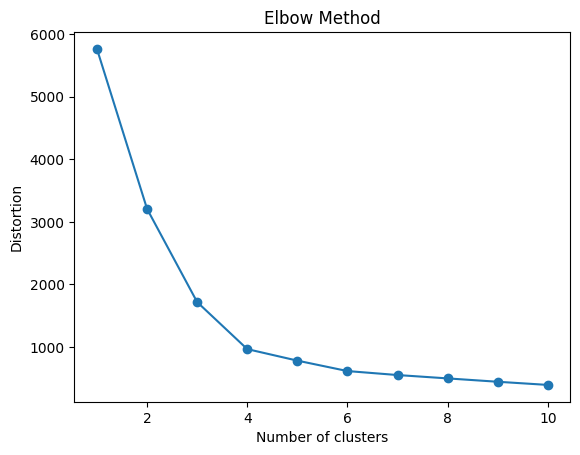

In [130]:
# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
features_pca = pca.fit_transform(data_model)

# Calculate distortion for a range of cluster numbers
distortions = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(features_pca)
    distortions.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.show()


From the elbow method, it's clear that k=4 is the optimal point! We use this k as number of segments for K-means clustering, as well as for Hierarchical Clustering and Density-based Clustering.

/Users/tanphan/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


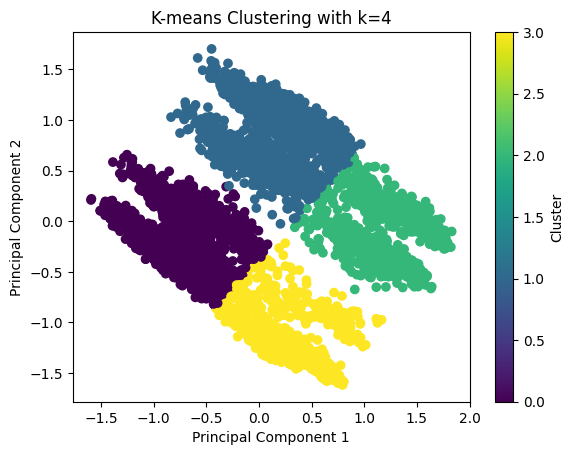

In [131]:
# Initialize and fit K-means clustering model with k=4 clusters
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(features_pca)

# Get cluster labels
cluster_labels = kmeans.labels_

# Visualize the clusters
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=cluster_labels, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-means Clustering with k=4')
plt.colorbar(label='Cluster')
plt.show()


Clusters are separated quite well! Let's discover key insights!

In [132]:
# Add cluster IDs to the dataset
merged_data['cluster_id_kmeans'] = cluster_labels

I will build a function segment_visualization, used to visualize insights for all 3 clustering models.

In [133]:
def segment_visualization(column):
    
    # 1. Visualize percentage of users by segment
    ## Get the percentage of users by segment
    user_percentages = merged_data[column].value_counts() / len(merged_data) * 100

    ## Plot the horizontal bar chart
    plt.figure(figsize=(8, 6))
    user_percentages.plot(kind='barh', color='green')
    plt.xlabel('Percentage of Users (%)')
    plt.ylabel('Segments')
    plt.title('Percentage of Users by Segment')
    plt.legend(fontsize='small')
    plt.gca().invert_yaxis()  # Invert y-axis to have Segment 1 at the top
    plt.show()

    #2. Visualize subscription status by segment
    subscription_by_segment = (merged_data.groupby(column)['purchased_subscription']
                            .value_counts(normalize=True)
                            .unstack('purchased_subscription')
                            .plot.bar(stacked=True))

    # Add title and labels
    plt.title('Subscription Percentage by Segment')
    plt.xlabel('Segment')
    plt.ylabel('x 100%')
    plt.legend(fontsize='small')
    plt.xticks(rotation=0)
    plt.show()

    #3. Visualize the language proficiency
    proficiency_by_segment = (merged_data.groupby(column)['primary_language_proficiency']
                            .value_counts(normalize=True)
                            .unstack('primary_language_proficiency')
                            .plot.bar(stacked=True))

    # Add title and labels
    plt.title('Proficiency Percentage by Segment')
    plt.xlabel('Segment')
    plt.ylabel('x 100%')
    plt.legend(fontsize='small')
    plt.xticks(rotation=0)
    plt.show()

    #4. Visualize engagement metrics
    # Get engagement metrics by age
    engagement_by_segment = merged_data.groupby(column)[['daily_goal', 'highest_course_progress','highest_crown_count', 'n_active_days', 'n_lessons_started', 'n_lessons_completed','longest_streak','n_days_on_platform']].median().style.background_gradient(cmap='RdYlGn')
    display(engagement_by_segment)

    #5. Visualize user commitment 
    commitment_by_segment = (merged_data.groupby(column)['primary_language_commitment']
                            .value_counts(normalize=True)
                            .unstack('primary_language_commitment')
                            .plot.bar(stacked=True))

    # Add title and labels
    plt.title('Commitment by Segment')
    plt.xlabel('Segment')
    plt.ylabel('x 100%')
    plt.legend(fontsize='xx-small')
    plt.xticks(rotation=0)
    plt.show()

    #5. Visualize language review
    language_review_by_segment = (merged_data.groupby(column)['primary_language_review']
                            .value_counts(normalize=True)
                            .unstack('primary_language_review')
                            .plot.bar(stacked=True))

    # Add title and labels
    plt.title('Language Review by Segment')
    plt.xlabel('Segment')
    plt.ylabel('x 100%')
    plt.legend(fontsize='xx-small', loc='upper right')
    plt.xticks(rotation=0)
    plt.show()

Let's visualize for K-means Clustering's segments:

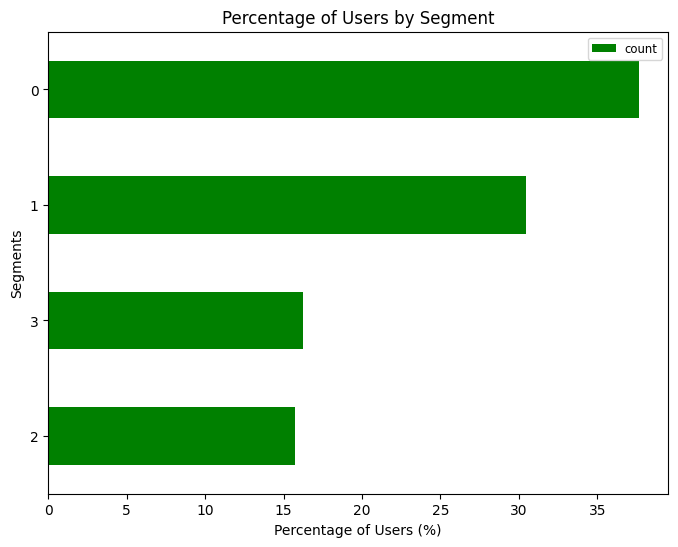

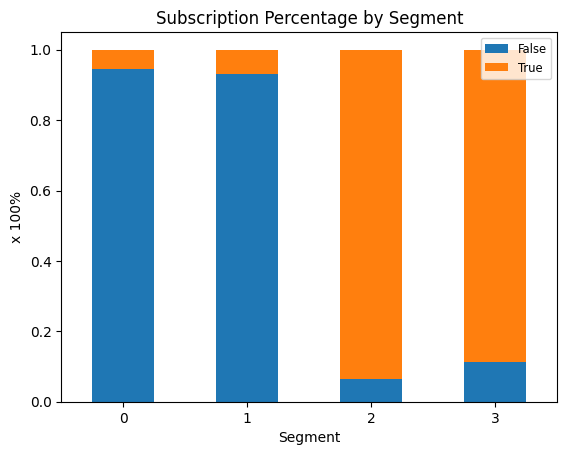

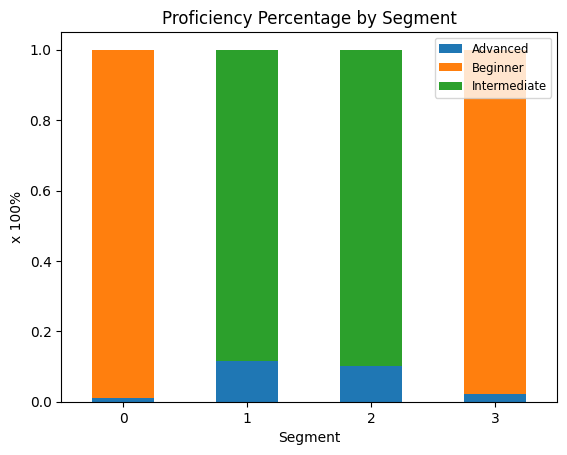

,daily_goal,highest_course_progress,highest_crown_count,n_active_days,n_lessons_started,n_lessons_completed,longest_streak,n_days_on_platform
cluster_id_kmeans,,,,,,,,
0,20.000000,15.000000,47.000000,26.000000,101.000000,94.000000,7.000000,280.000000
1,20.000000,31.000000,99.000000,35.000000,133.000000,125.000000,11.000000,569.500000
2,30.000000,34.000000,175.000000,86.000000,319.000000,300.000000,102.500000,653.000000
3,20.000000,25.000000,93.000000,76.000000,269.000000,251.000000,48.500000,319.500000


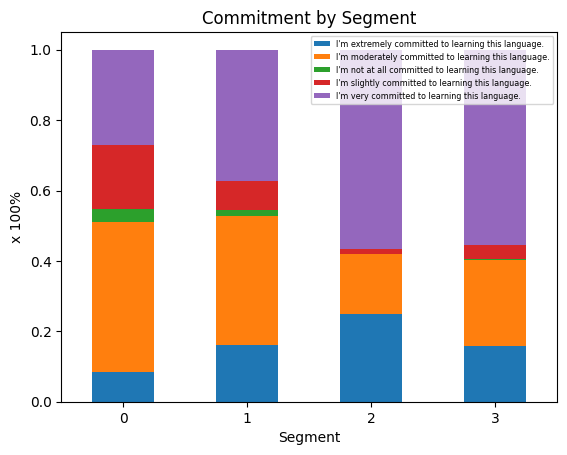

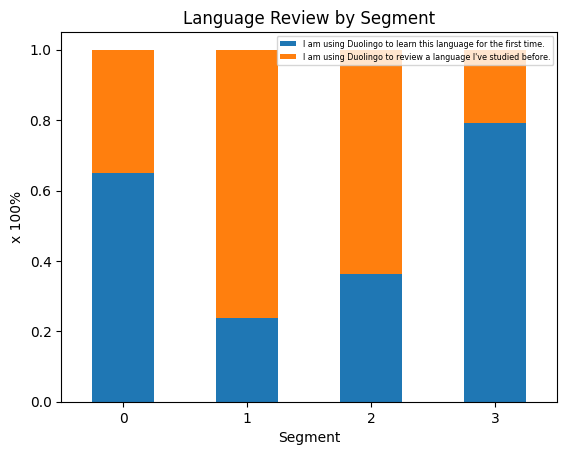

In [134]:
segment_visualization('cluster_id_kmeans')

Description of User Segment:

1. **Highly-engaged subscribers (cluser 2)**
The segment accounts for 16% of all users. More than 80% are 35+ years old (50% are more than 55% year old) with good income. They know the primary language before learning on Duolingo. With high commitment, they become the most engaged group. 

2. **Beginner Subscription Learners (cluser 3)**
The group makes up 18% of all users. 80% of them are 35+ years old. Although they learn the language for the first time, their engagement and consistency is impressive.

3. **Freemium Language Reviewers (cluser 1)**
This group accounts for 30% of all users. They are diverse in terms of age, income and employment status. They use Duolingo mainly to review languages they already know. Their engagement is medium - around 50% of subscribers’.

4. **Curious Free Beginners (cluser 0)**
This is the largest group (36% of all users). They are just language beginners and want to explore the language. However, they seem stuck with lowest engagement.


### Hierarchical Clustering (for reference) ###

In [135]:
# Fit Hierarchical Clustering to the data with linkage = 'ward'
hierarchical_clustering = AgglomerativeClustering(n_clusters=4, linkage='ward')
cluster_labels = hierarchical_clustering.fit_predict(data_model)

In [136]:
#Add cluster labels to the dataset
merged_data['cluster_id_hc'] = cluster_labels

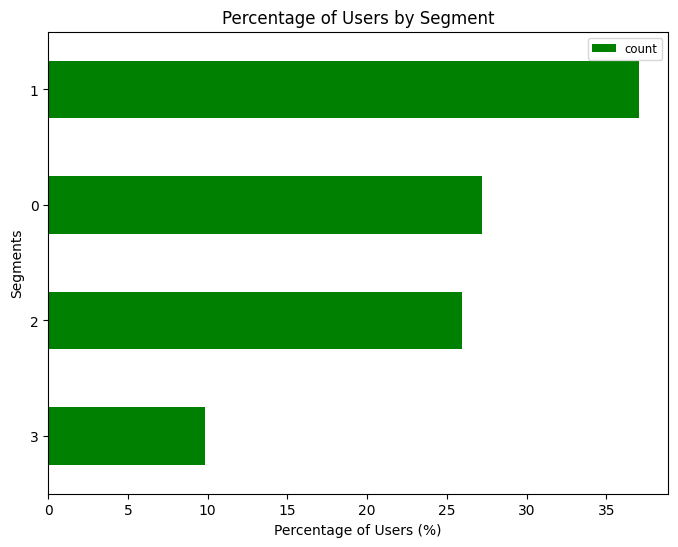

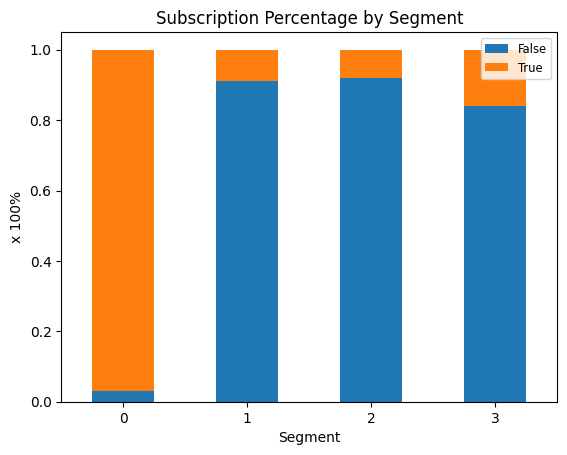

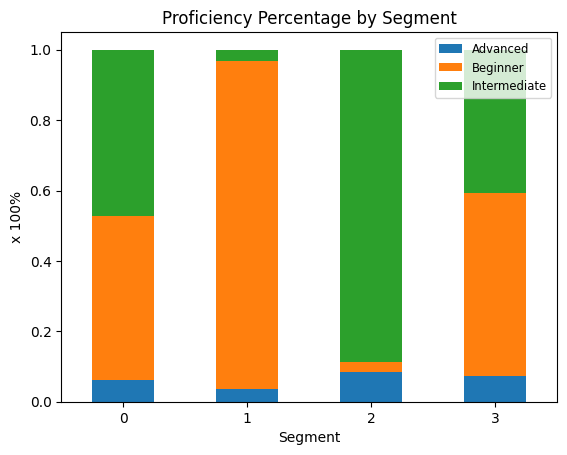

,daily_goal,highest_course_progress,highest_crown_count,n_active_days,n_lessons_started,n_lessons_completed,longest_streak,n_days_on_platform
cluster_id_hc,,,,,,,,
0,20.000000,33.000000,141.000000,84.000000,301.000000,287.000000,81.000000,511.000000
1,20.000000,16.000000,53.000000,30.000000,112.000000,103.000000,8.000000,306.000000
2,20.000000,31.000000,108.000000,41.500000,156.000000,147.000000,15.000000,584.500000
3,30.000000,18.000000,45.000000,19.000000,80.000000,73.000000,6.000000,339.000000


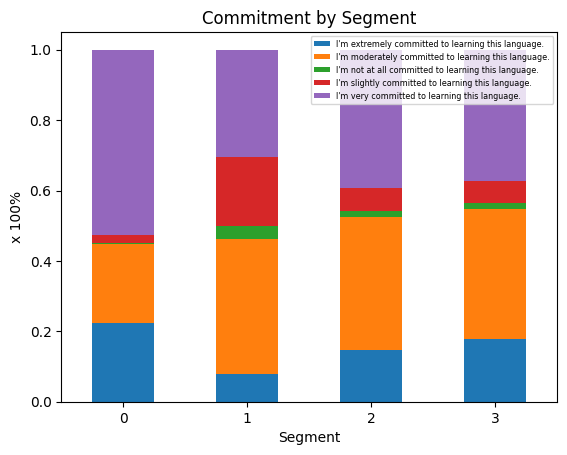

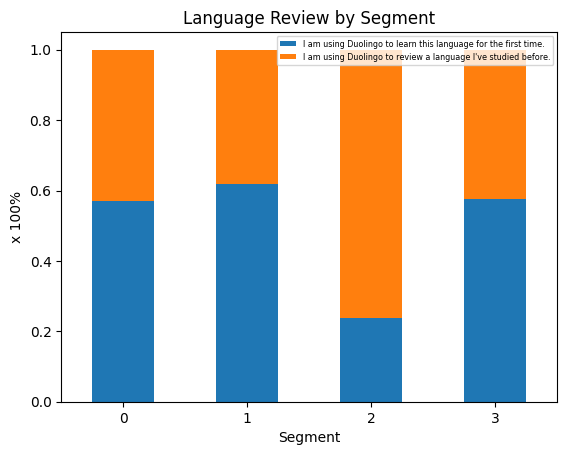

In [137]:
segment_visualization('cluster_id_hc')

## Section 5: Conclusion and Business Applications ##

1. **Subscribers are our top prioritized segment** because they very likely generate the most revenue. The goal is to provide them with the best learning experience and make them re-new subscription. With high contribution of adult/senior learners (35+ years old), together with high commitment and engagement, we should:
- Design learning paths with a focus on older adult learning styles and preferences
- Offer more advanced courses challenges for the advanced learners. 
- Promote social features (such as Add friends) within the app to connect them with other engaged learners.
- For marketing, showcase stories of successful late-in-life language learners and partner with organizations/companies catering to mature/senior audiences.

2. **For Freemium Language Reviewers, the goal is to convert them to subscribers,** because they are the potential group to become the Highly-engaged subscribers: have intermediate proficiency for primary language before using the app and medium engagement.
- Highlight the added subscription values. Recognize their hard work and offer 4-week free trial subscription instead of 2 week ones
- Introduce more advanced courses based on their interest to increase their engagement.
- For marketing, emphasize the importance of reviewing a language, leveraging that precious foundation to continue improving.
- As mentioned, they are a diverse group, therefore, we should further segment/analyze them to understand their challenges/pain points for more relevant strategy.

3. **For Curious Beginners, they are the biggest but riskiest group!** Most of them are beginners but they have very low engagement, potentially suggesting that they do not find it interesting to learn on Duolingo. 
- Quickly captivating the interest of this group at the beginning is important! Revamp the first courses to make sure that they can realize the quick win.
- Offer personalized learning paths based on their interests and goals to increase their engagement.
- Further analysis on their commitment/motivation is recommended to increase their motivation. The current data is not enough to tell why they have low commitment.
- If watching ads is a reason leading to their low engagement, offering them 3-week free trial subscription and recognizing their improved performance after the trial.

4. **Next steps:**
- Further analysis on the reasons why users subscribe and users’ pain points are highly recommended to have a better understanding.
- Conduct the user segmentation by country, understanding the reason why, for some countries such as Japan and France, the subscription ratio is much higher than others’ and allowing to localize the product in each country.
